# Meta Computer

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

C:\Users\krist\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spam.py:111: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if init is "random":
C:\Users\krist\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spam.py:115: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif init is "ideal":
C:\Users\krist\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spam.py:125: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if povm is "random":
C:\Users\krist\Documents\ModelNISQ\notebooks\experiments\../../src_tf\spam.py:133: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif povm is "ideal":


## Three Qubit 

## Belem

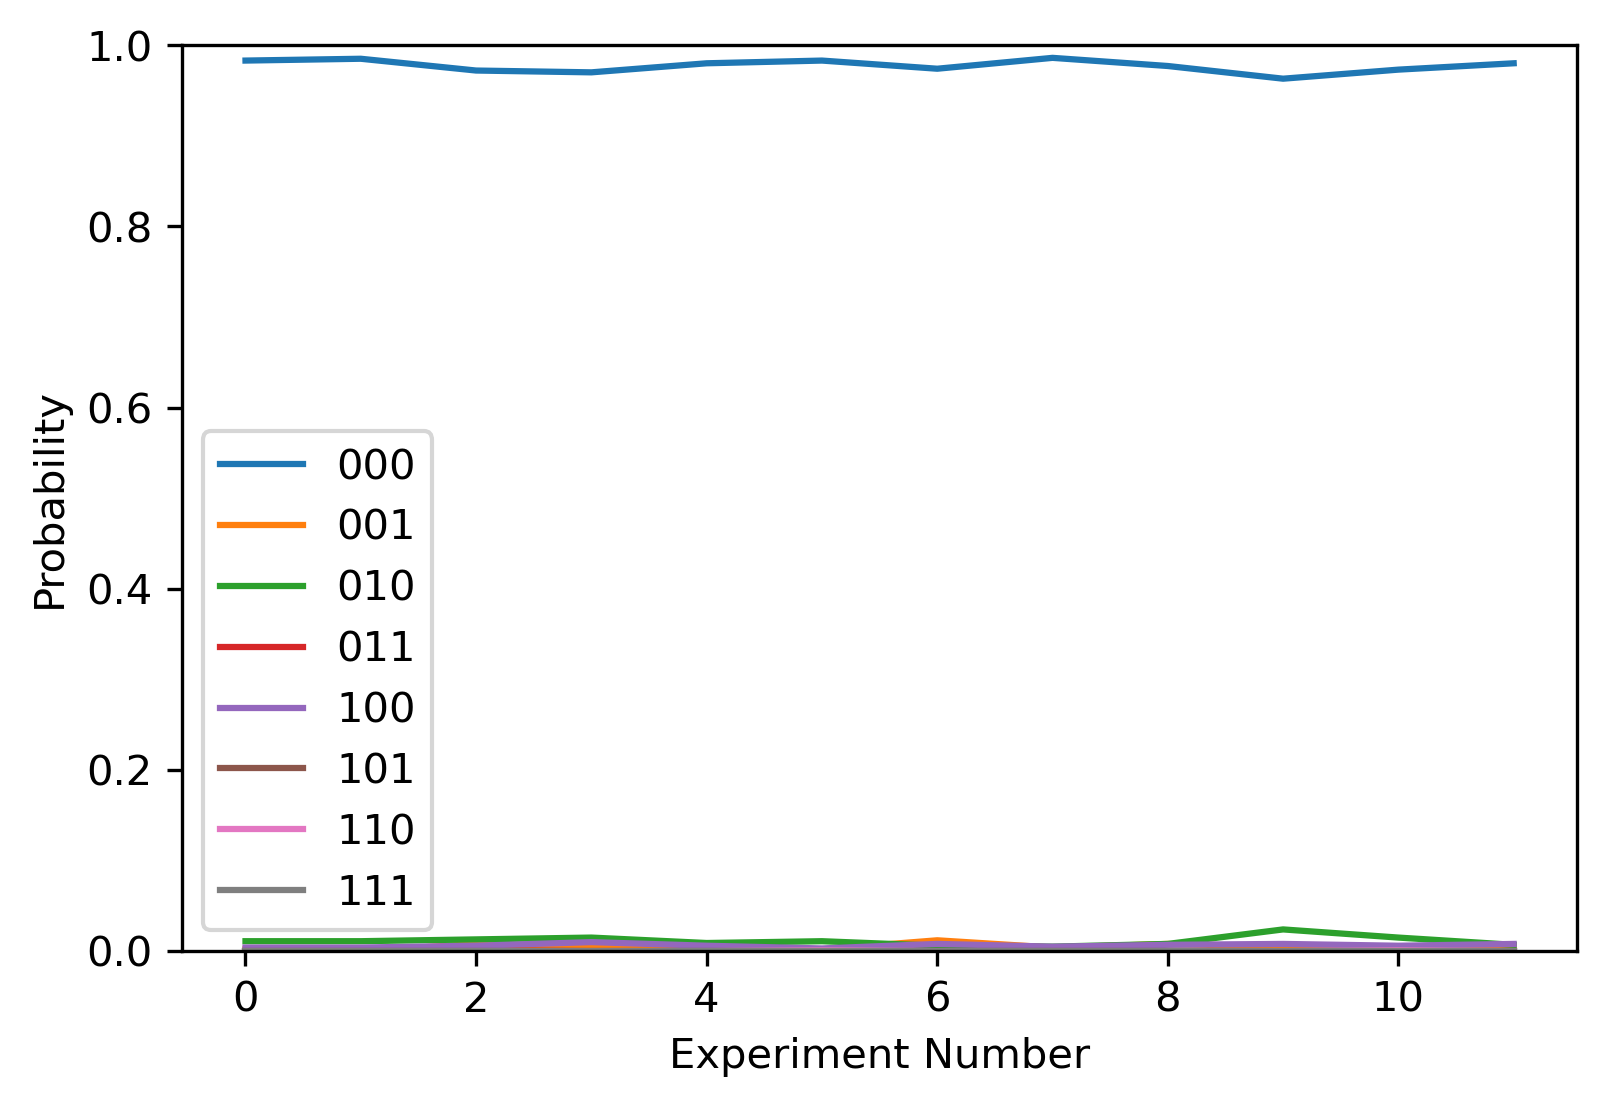

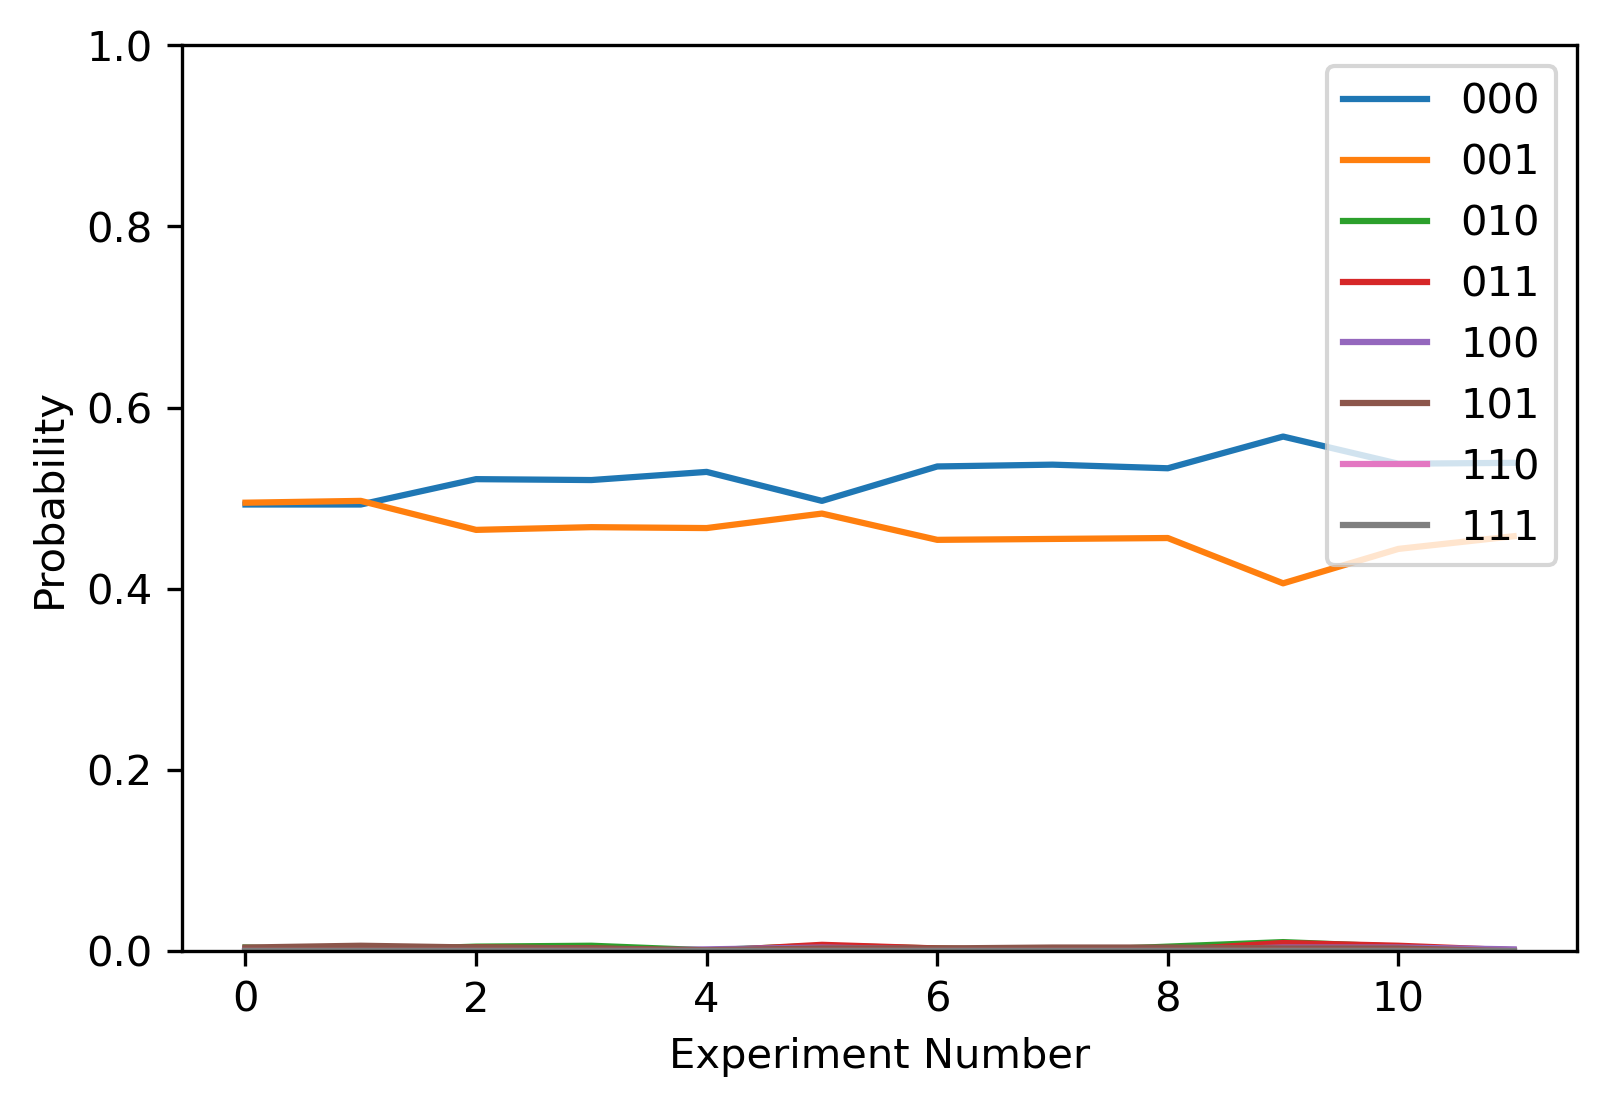

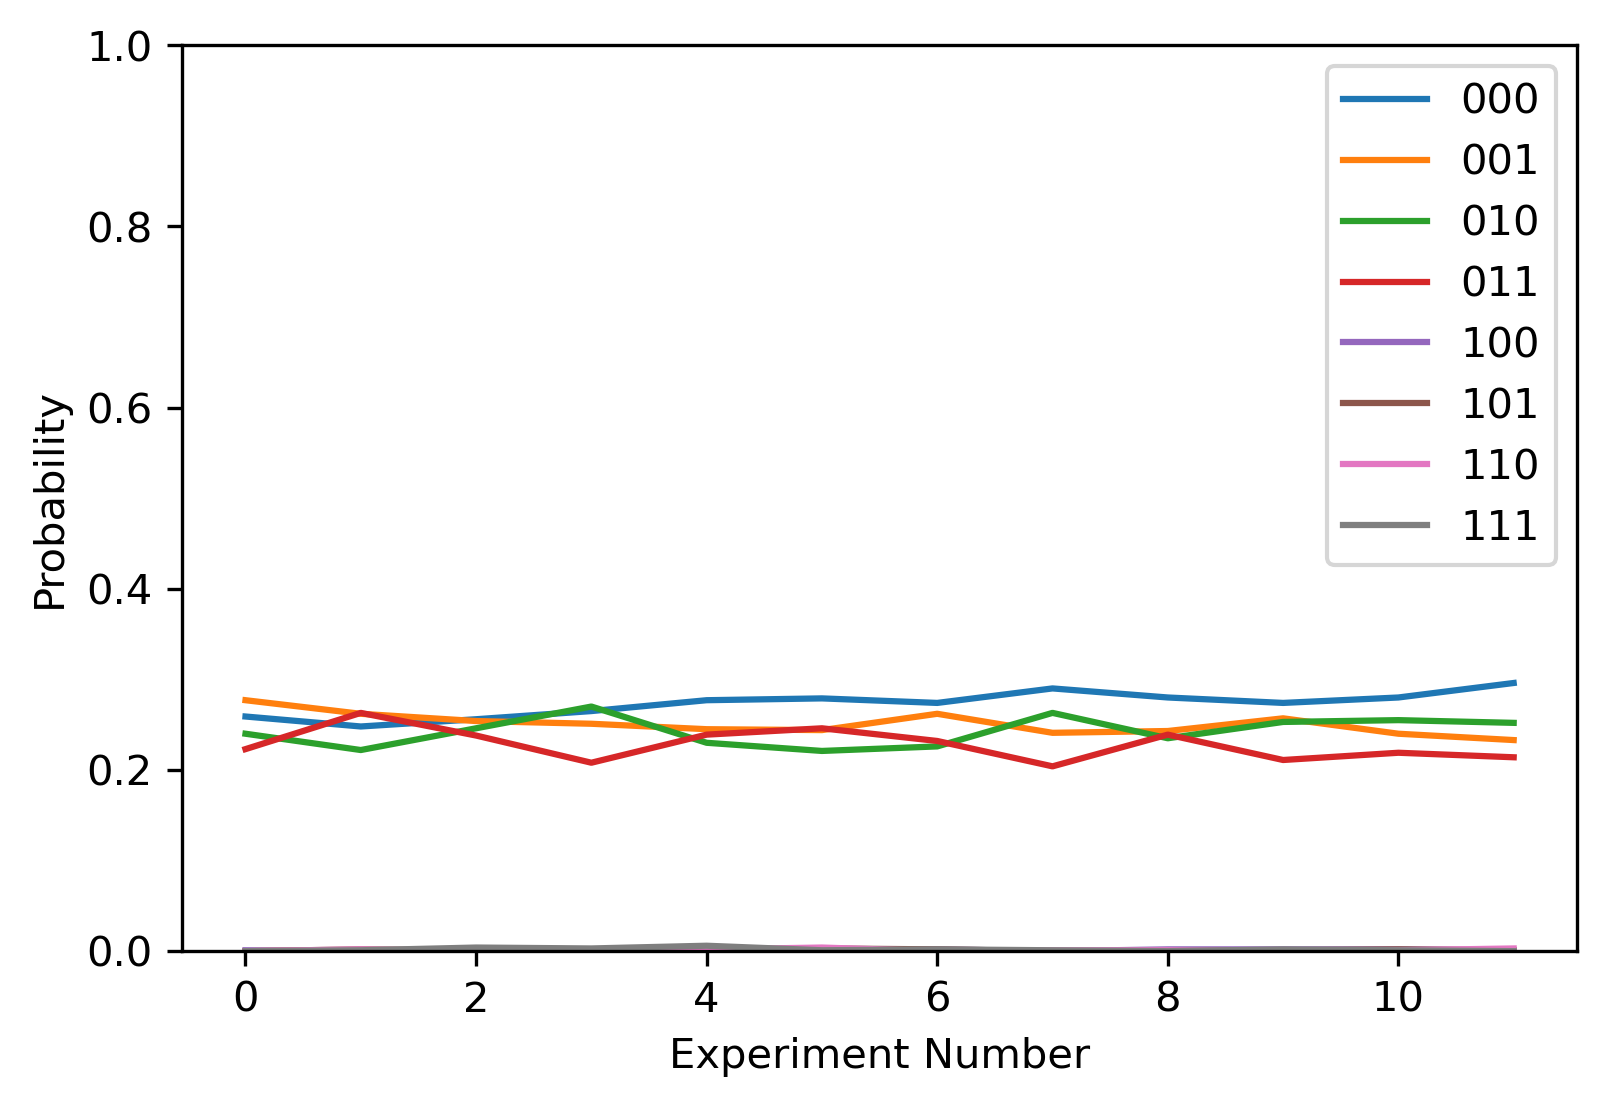

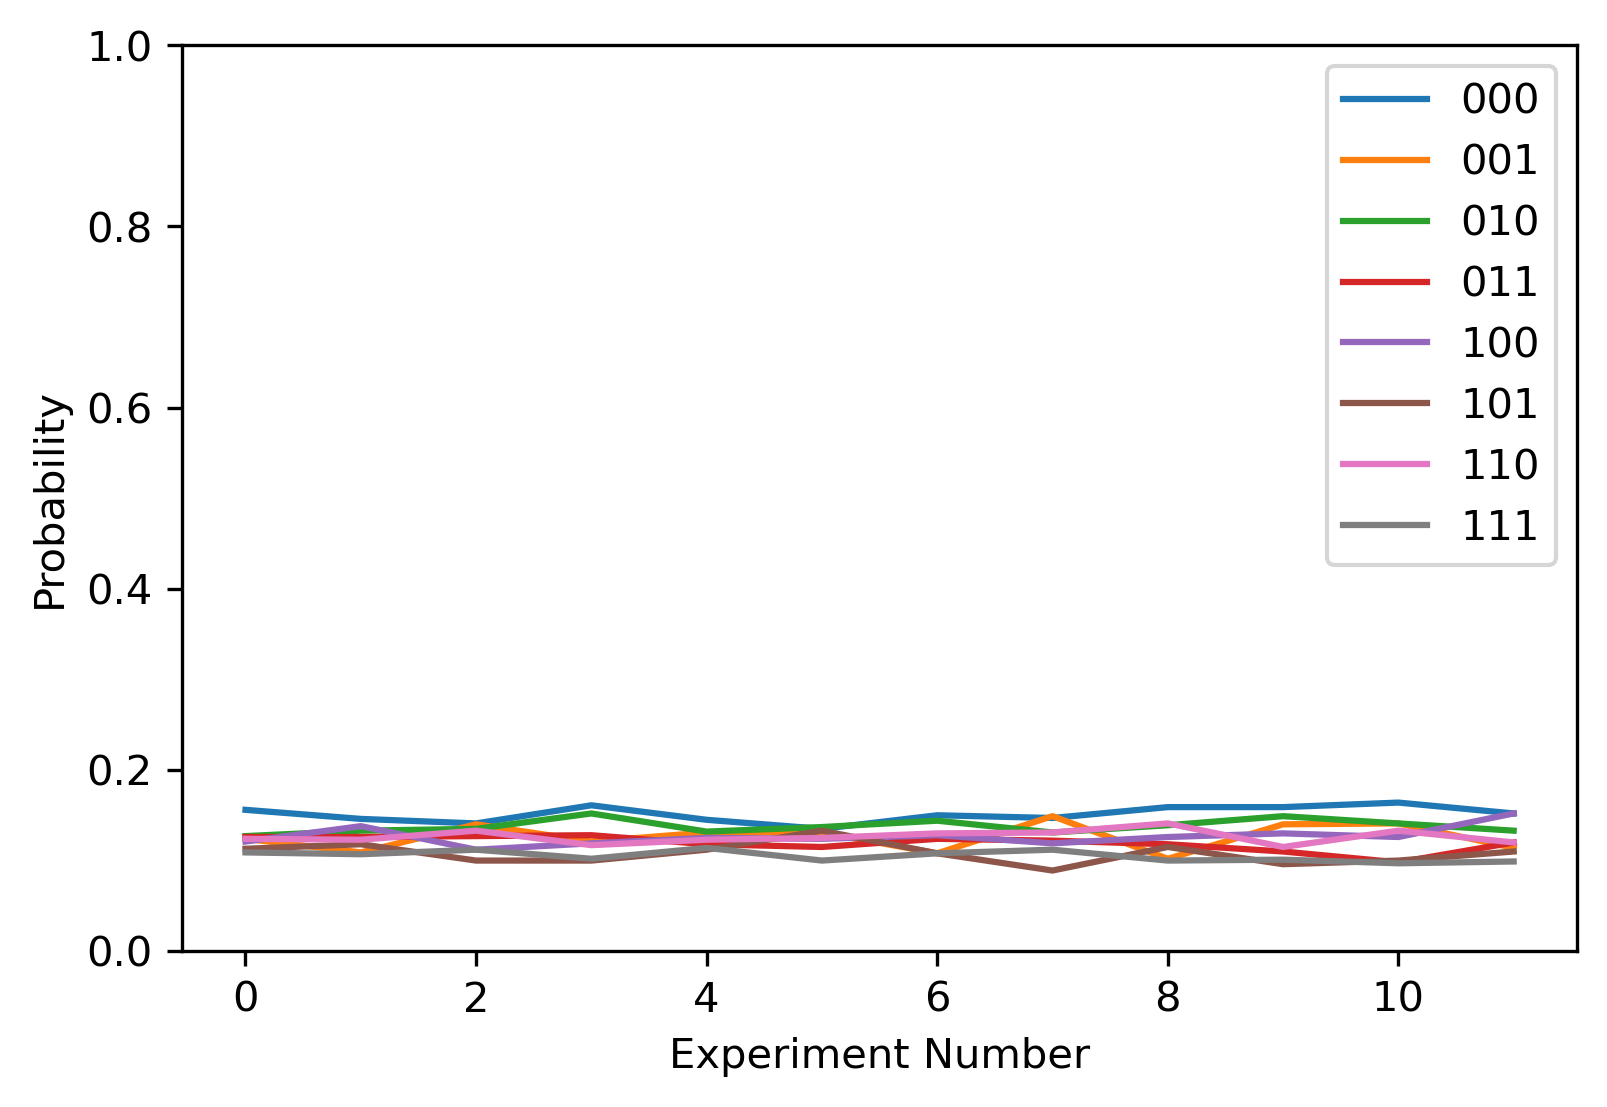

In [42]:
n = 3
index = 0
y = []

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])


_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(y)
plt.xlabel("Experiment Number")
plt.ylabel("Probability")
plt.ylim([0,1])
plt.legend(["000", "001", "010", "011", "100", "101", "110", "111"])
#plt.yscale("log")
plt.show()

n = 3
index = 2
y = []

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])


_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(y)
plt.xlabel("Experiment Number")
plt.ylabel("Probability")
plt.legend(["000", "001", "010", "011", "100", "101", "110", "111"])
plt.ylim([0,1])
plt.show()

n = 3
index = 14
y = []

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])


_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

n = 3

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(y)
plt.xlabel("Experiment Number")
plt.ylabel("Probability")
plt.legend(["000", "001", "010", "011", "100", "101", "110", "111"])
plt.ylim([0,1])
plt.show()

n = 3
index = 86
y = []

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])


_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

n = 3

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{0}.p", "rb"))
targets_spam0 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{1}.p", "rb"))
targets_spam1 = counts_to_probs(counts_list[2000-6**n:])

_, _, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{2}.p", "rb"))
targets_spam2 = counts_to_probs(counts_list[2000-6**n:])

y.extend([np.real(targets_spam0[index]), np.real(targets_spam1[index]), np.real(targets_spam2[index])])

fig=plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(y)
plt.xlabel("Experiment Number")
plt.ylabel("Probability")
plt.legend(["000", "001", "010", "011", "100", "101", "110", "111"])
plt.ylim([0,1])
plt.show()